# Lecture 13

### A/B Testing

## Today's lecture

- So far, we've been assessing models given a single random sample.
    - We flip a coin 400 times. Are the flips consistent with the coin being fair?
    - Did the jury panel in the Swain case look like a random sample from the eligible population?
    - Are the test scores for the GSI's section a random sample from the class's scores?
- But we often have *two* random samples we wish to compare.
    - Outcomes of patients assigned to control group and treatment group in a pharmaceutical study.
    - Number of clicks from people who saw version A of an advertisement vs. version B
- **A/B testing**: decide whether two random samples come from the same distribution.
- The "exciting" outcome is typically that which *rejects* the null hypothesis.

# Example 1: Birth Weight and Smoking

## Smoking and birth weight

- Is there a significant difference in the weight of babies born to mothers who smoke, vs. non-smokers?
- Two groups:
    - babies whose mothers smoke
    - babies whose mothers do not smoke

In [1]:
#: the usual imports
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

In [2]:
#: our data
baby = Table.read_table('babby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [3]:
#: we only need "Birth Weight" and "Maternal Smoker"
smoking_and_birthweight = baby.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


## First, some exploratory analysis

In [4]:
# how many are in each group?
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


In [5]:
# what is the average weight within each group?
smoking_and_birthweight.group('Maternal Smoker', np.mean)

Maternal Smoker,Birth Weight mean
False,123.085
True,113.819


## Visualizing the distribution of each group

- `.hist()` has a `group` keyword argument.

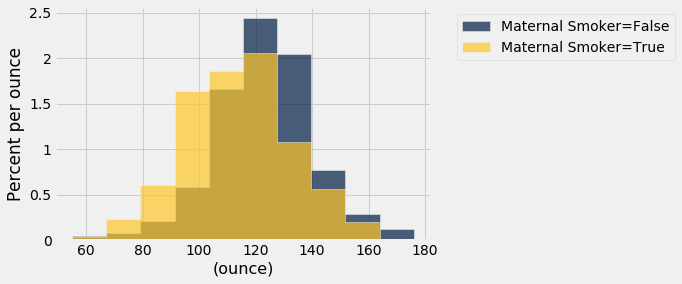

In [6]:
# visualize distribution of 'Birth Weight', grouped by 'Maternal Smoker'
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker', unit='ounce')

## The question...

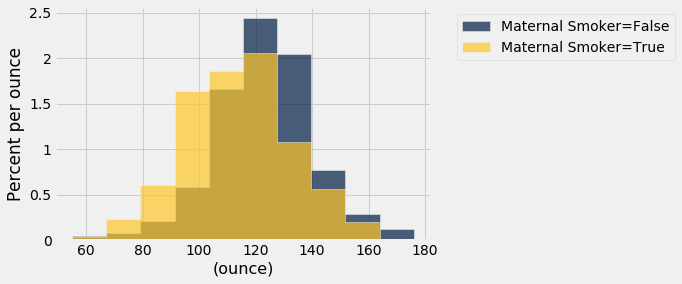

In [7]:
#::
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker', unit='ounce')

- Does the difference we see reflect a real difference in the population?
- Or is it just due to random chance?

## Testing the hypotheses

- **Null hypothesis**: In the population, birth weights of smokers and non-smokers have the same distribution.
    - I.e., what we saw is due to random chance.
- **Alternative hypothesis**: In the population, babies born to smokers typically have lower birth weight.

## Discussion question

- What is a reasonable statistic to compute in order to test the null hypothesis?

## Answer: difference between means

In [8]:
#:: the means
means_table = smoking_and_birthweight.group('Maternal Smoker', np.mean)
means_table

Maternal Smoker,Birth Weight mean
False,123.085
True,113.819


In [9]:
#: difference between them
means = means_table.column('Birth Weight mean')
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

## Testing through simulation

- **Statistic**: Difference between means.
- **Null hypothesis**: The two groups are sampled from the same distribution.
- Note that the null hypothesis doesn't say *what* the distribution is.
    - Different from jury panel example, fair coin example, etc.
    - We can't draw directly from the distribution!
- We have to do something a bit more clever.

## Implications of the null hypothesis

- Under the null hypothesis, both groups are sampled from the same distribution.
- If true, then the group label (`Maternal Smoker`) has no effect on the birth weight.
- We saw one assignment of group labels:

In [10]:
#:: the data
smoking_and_birthweight.show(4)

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108


- But (under the null hypothesis) we were just as likely to see *any other* assignment.

## Permutation tests

- Perhaps the difference in means we saw is due to random chance in assignment.
- **Permutation test**: Shuffle the group labels a bunch of times; how often do we see a statistic this extreme?
- Randomly permuting labels is equivalent to randomly assigning birth weights to groups (without changing group sizes)
- If we *rarely* see something this extreme, then the null hypothesis doesn't look likely.

## Permutation tests with tables

- We want to randomly shuffle the `Maternal Smoker` column.
- We can use `.sample(with_replacement=False)`.
- By default, draws as many times as there are rows (i.e., shuffles)

In [11]:
#: starting with this data...
data = Table(['x', 'y']).with_rows([['a', 1], ['b', 2], ['c', 3]])
data

x,y
a,1
b,2
c,3


In [12]:
#: we shuffle the rows using `.sample()`
data.sample(with_replacement=False)

x,y
b,2
c,3
a,1


- Notice: Both rows are shuffled together (i.e., not independently)!

## Discussion Question

In the birthweight example, we want to shuffle only one column. For the purpose of permutation testing, 
does it matter which column we shuffle -- the `Maternal Smoker` column or the `Birth Weight` column?

- A) Yes
- B) No

## Shuffling the groups

In [13]:
#: it doesn't matter which column we shuffle, but it will be more convenient to shuffle weights
shuffled_weights = smoking_and_birthweight.sample(with_replacement=False).column('Birth Weight')
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Birth Weight', shuffled_weights)
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Birth Weight
False,120,118
False,113,142
True,128,139
True,108,123
False,136,99
False,138,130
False,132,174
False,120,158
True,143,85
False,140,127


## How close are the means of the shuffled groups?

In [14]:
#: shuffling the weights makes it easier to do this...
original_and_shuffled.group('Maternal Smoker', np.mean)

Maternal Smoker,Birth Weight mean,Shuffled Birth Weight mean
False,123.085,120.274
True,113.819,118.198


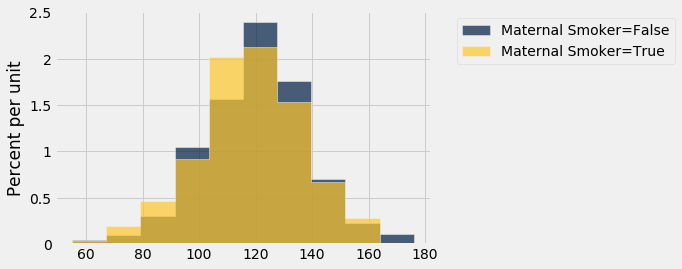

In [15]:
#: the distribution of the shuffled groups
original_and_shuffled.hist('Shuffled Birth Weight', group='Maternal Smoker')

## Simulation

- This was just one random shuffle.
- How likely is it that a random shuffle results in a 9+ ounce difference in means?
- We have to repeat the shuffling a bunch of times. On each iteration:
    1. Shuffle the weights.
    2. Put them in a table.
    3. Compute difference in group means.

In [16]:
n_repetitions = 500

differences = make_array()
for i in np.arange(n_repetitions):
    # shuffle the weights
    shuffled_weights = (
        smoking_and_birthweight
        .sample(with_replacement=False)
        .column('Birth Weight')
    )
    
    # put them in a table
    shuffled = smoking_and_birthweight.with_column(
        'Shuffled Birth Weights', 
        shuffled_weights
    )
    
    # compute the group differences
    group_means = (
        shuffled
        .group('Maternal Smoker', np.mean)
        .column('Shuffled Birth Weights mean')
    )
    difference = group_means.item(1) - group_means.item(0)
    
    # add it to our array storing the results
    differences = np.append(differences, difference)

## Conclusion of the test

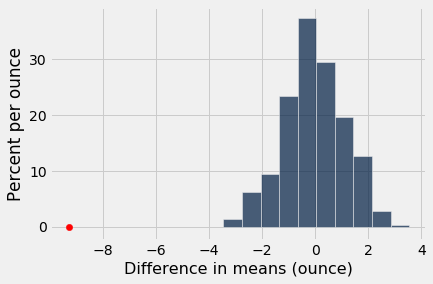

In [17]:
#: visualize
Table().with_columns('Difference in means', differences).hist(unit='ounce')
plt.scatter(observed_difference, 0, color='red', s=40)

- Under the null hypothesis, we rarely see differences as large as this.
- Therefore, we reject the null hypothesis: the two groups do not come from the same distribution.

## Caution!

- We **cannot** conclude that smoking *causes* lower birth weight!
- This was an observational study; there may be confounding factors.
    - Maybe smokers are more likely to drink caffeine, and caffeine causes lower birth weight.
- But it suggests that it is worth studying with a randomized controlled trial.

## A slightly different example

- Is there a difference in birthweight between babies born to:
    - Group A: Mothers over 25
    - Group B: Mothers 25 or under

In [18]:
#: construct the data set
over_25 = baby.column('Maternal Age') > 25
age_and_birthweight = (
    baby
    .select('Birth Weight')
    .with_column('Over 25', over_25)
)
age_and_birthweight

Birth Weight,Over 25
120,True
113,True
128,True
108,False
136,False
138,True
132,False
120,False
143,True
140,True


In [19]:
#: the group means
group_means = age_and_birthweight.group('Over 25', np.mean)
group_means

Over 25,Birth Weight mean
False,118.495
True,120.229


In [20]:
#: the difference between them
means = group_means.column('Birth Weight mean')
observed_difference = means.item(0) - means.item(1)
observed_difference

-1.7338245892717907

## The permutation test

- **Null hypothesis**: Birth weights for both groups come from the same distribution.
- **Alternative hypothesis**: No, mothers below 25 have heavier babies.
- We run a permutation test with the difference in means as the statistic.

## Simulation

In [21]:
#: similar code to before

np.random.seed(424242)
n_repetitions = 500

differences = make_array()
for i in np.arange(n_repetitions):
    # shuffle the weights
    shuffled_weights = (
        age_and_birthweight
        .sample(with_replacement=False)
        .column('Birth Weight')
    )
    
    # put them in a table
    shuffled = age_and_birthweight.with_column(
        'Shuffled Birth Weights', 
        shuffled_weights
    )
    
    # compute the group differences
    group_means = (
        shuffled
        .group('Over 25', np.mean)
        .column('Shuffled Birth Weights mean')
    )
    difference = group_means.item(1) - group_means.item(0)
    
    # add it to our array storing results
    differences = np.append(differences, difference)

## Conclusion of the test

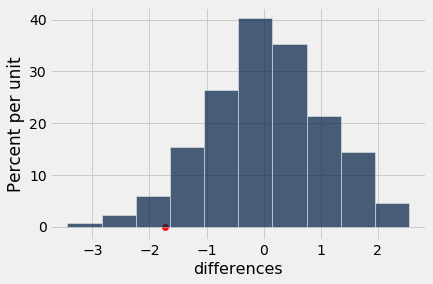

In [22]:
#: visualize
Table().with_column('differences', differences).hist()
plt.scatter(observed_difference, 0, color='red', s=40)

- Do we reject the null hypothesis?
- What can we compute to tell us the degree of uncertainty here?

## The p-value

- The probability of seeing a difference of means $\leq$ the observed, under the null hypothesis.

In [23]:
np.count_nonzero(differences <= observed_difference) / n_repetitions

0.042

# Example 2: Deflategate

## Did the New England Patriots cheat?

<img height="30%" src="./deflate.jpg">

- On January 18, 2015, the Patriots played the Indianapolis Colts for a spot in the Super Bowl
- The Patriots won, 45 -- 7. They went on to win the Super Bowl
- After the game, it was alleged that the Patriots intentionally deflated footballs (making them easier to catch)

## Background

- Each team brings 12 footballs to the game.
- NFL rules stipulate: each ball must be inflated to between 12.5 and 13.5 pounds per square inch (psi).
- Before the game, officials found that all of the Patriot's balls were at about 12.5 psi, all of the Colts were about 13.0 psi.
- In the second quarter, Colts intercepted a Patriots ball and notified officials that it felt under-inflated.
- At halftime, two officials (Blakeman and Prioleau) each measured the pressure again.
- They ran out of time, and couldn't measure the pressure of all of the footballs.

## The measurements

In [24]:
#: all of the measurements
footballs = Table.read_table('./deflategate.csv')
footballs.show()

Team,Blakeman,Prioleau
Patriots,11.5,11.8
Patriots,10.85,11.2
Patriots,11.15,11.5
Patriots,10.7,11
Patriots,11.1,11.45
Patriots,11.6,11.95
Patriots,11.85,12.3
Patriots,11.1,11.55
Patriots,10.95,11.35
Patriots,10.5,10.9


## Combining the measurements

- Both officials measured each ball.
- Their measurements are slightly different.
- We average them to get a combined weight.

In [25]:
#: a combined measurement
footballs = footballs.with_column(
    'Combined',
    (footballs.column('Blakeman') + footballs.column('Prioleau')) / 2
)
footballs.show()

Team,Blakeman,Prioleau,Combined
Patriots,11.5,11.8,11.65
Patriots,10.85,11.2,11.025
Patriots,11.15,11.5,11.325
Patriots,10.7,11,10.85
Patriots,11.1,11.45,11.275
Patriots,11.6,11.95,11.775
Patriots,11.85,12.3,12.075
Patriots,11.1,11.55,11.325
Patriots,10.95,11.35,11.15
Patriots,10.5,10.9,10.7


## Differences in average pressure

- At first glance, it looks as though the Patriots footballs are at a lower pressure.

In [26]:
#:: group means
footballs.group('Team', np.mean)

Team,Blakeman mean,Prioleau mean,Combined mean
Colts,12.625,12.4375,12.5312
Patriots,11.1091,11.4864,11.2977


- We could do a permutation test for difference in mean pressure.
- But that wouldn't point towards cheating.
    - The Patriot's balls *started* at a lower psi.
- The allegations were that the Patriots *deflated* the balls.
    - We want to check to see if the Patriots balls lost more pressure than the Colts'.

## Calculating the pressure drop

- We therefore calculate the drop in pressure for each ball.
- Patriots' started at 12.5 psi, Colts' started at 13.
- We make an array with starting pressure for each ball.
- Handy function: `np.where(array_of_true_and_false, true_value, false_value)`.
    - Replaces `True` in the array with `true_value`, and `False` with `false_value`.

In [27]:
#...starting_pressure
starting_pressure = np.where(
    footballs.column('Team') == 'Patriots',
    12.5,
    13
)
starting_pressure

array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
       13. , 13. , 13. , 13. ])

## Calculating the pressure drop

In [28]:
#: add the drop to the table
footballs = footballs.with_column(
    'Pressure Drop',
    starting_pressure - footballs.column('Combined')
)
footballs.show()

Team,Blakeman,Prioleau,Combined,Pressure Drop
Patriots,11.5,11.8,11.65,0.85
Patriots,10.85,11.2,11.025,1.475
Patriots,11.15,11.5,11.325,1.175
Patriots,10.7,11,10.85,1.65
Patriots,11.1,11.45,11.275,1.225
Patriots,11.6,11.95,11.775,0.725
Patriots,11.85,12.3,12.075,0.425
Patriots,11.1,11.55,11.325,1.175
Patriots,10.95,11.35,11.15,1.35
Patriots,10.5,10.9,10.7,1.8


## The question

- Did the Patriots' footballs drop in pressure more than the Colts'?
- A/B test!
- **Null hypothesis**: The drop in pressures for both teams came from the same distribution.
    - By chance, the Patriots' footballs deflated more.
- **Alternative hypothesis**: No, the Patriots' footballs deflated more than one would expect due to random chance alone.

## The statistic

- Difference between teams' average pressure drops.

In [29]:
#: the group means
means = footballs.group('Team', np.mean).select('Team', 'Pressure Drop mean')
means

Team,Pressure Drop mean
Colts,0.46875
Patriots,1.20227


In [30]:
#: the observed difference
mean_drop = means.column('Pressure Drop mean')
observed_difference = mean_drop.item(1) - mean_drop.item(0)
observed_difference

0.733522727272728

- The average pressure drop for the Patriots was 0.73 psi more than the Colts.

## Permutation test

- We run a permutation test to see if this is a significant difference.
- Permute the drop in pressure (or the team column), many times.

In [31]:
#: run a permutation test
n_repetitions = 5000

differences = make_array()
for i in np.arange(n_repetitions):
    # shuffle the weights
    shuffled_drops = (
        footballs
        .sample(with_replacement=False)
        .column('Pressure Drop')
    )
    
    # put them in a table
    shuffled = footballs.with_column(
        'Shuffled Pressure Drop', 
        shuffled_drops
    )
    
    # compute the group differences
    group_means = (
        shuffled
        .group('Team', np.mean)
        .column('Shuffled Pressure Drop mean')
    )
    difference = group_means.item(1) - group_means.item(0)
    
    # add it to our array storing results
    differences = np.append(differences, difference)

## Conclusion

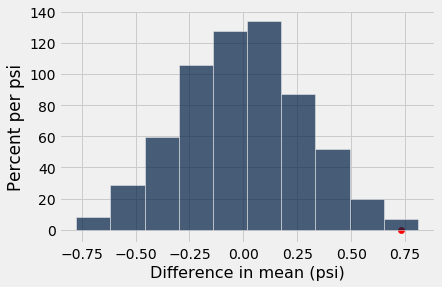

In [32]:
#:: visualize
Table().with_column('Difference in mean', differences).hist(unit='psi')
plt.scatter(observed_difference, 0, color='red', s=40)

- It doesn't look good for the Patriots. What is the p-value?

In [33]:
#: p-value
np.count_nonzero(differences >= observed_difference) / n_repetitions

0.0036

## Caution!

- We conclude that it is unlikely that the difference in mean pressure drop is due to chance alone.
- But this doesn't establish *causation*.
- That is, did the Patriots *deliberately* deflate their footballs?
- This was an *observational* study; to establish causation, we need an RCT (Randomized Controlled Trial).

# Causality

## Recap

- We have used A/B testing to assess group differences.
- Example:
    - Study: Babies born to mothers who smoke typically weigh less.
    - Permutation test conclusion: this is unlikely to be due to random chance.
- Rejecting the null hypothesis **does not** establish causality.
    - Tempting to think that smoking causes lower birthweight.
    - But there could be **confounding factors**...
    - Maybe *caffeine* causes lower birthweight, and caffeine intake is correlated with smoking.

## Randomized Controlled Trial

- This was an **observational study**.
- We've seen that randomizing groups then applying "treatment" avoids confounding factors.
- This is known as a **Randomized Controlled Trial** (RCT).
- An A/B test in a RCT *does* support causality.

## Why?

- Suppose we want to examine the link between chocolate and heart health.
- We do an observational study and see that chocolate-eaters have healthier hearts.

In [34]:
#: chocolate and heart health
Table.read_table('coffee_observational.csv').select('Chocolate', 'Good Heart')

Chocolate,Good Heart
1,1
1,0
1,1
1,1
1,1
0,0
0,0
0,1
0,0
0,0


- We want to say that eating chocolate *causes* good heart health.
- But it turns out that chocolate-eaters are more likely to consume caffeine.
- And suppose it is *caffeine* which actually helps heart health.

In [35]:
#: chocolate, caffeine, and heart health
Table.read_table('coffee_observational.csv')

Chocolate,Good Heart,Caffeine
1,1,0
1,0,1
1,1,1
1,1,1
1,1,1
0,0,0
0,0,0
0,1,1
0,0,0
0,0,1


## Why?

- The chocolate-eating group had better health because it had more caffeine consumers.
- Now suppose we do an RCT and select random groups.
- *Then* we apply the treatment (chocolate).

In [36]:
#: the rct results
Table.read_table('coffee_rct.csv')

Caffeine,Chocolate,Good Heart
1,1,1
0,1,0
1,1,1
0,1,0
0,1,1
1,0,1
0,0,0
0,0,0
1,0,1
1,0,1


- Randomization ensures that the caffeine consumers are (roughly) divided between the treatment and control group.
- The effect of the confounding factor is mitigated.

## Example: Chronic Back Pain

In [37]:
#: the usual imports
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

## Treatment with botulinum toxin

- Botulinum Toxin A is the "most acutely lethal toxin known" (Wikipedia).
    - About 100 *nanograms* injected intravenously is lethal to a human.
- Used for treating muscle disorders and for cosmetic reasons (Botox).
- A randomized controlled study examined the use of Botulinum Toxin A in the treatment of lower back pain.
    - 31 patients with pain were randomly assigned to control and treatment groups.
    - Control group received placebo (saline).
    - Treatment group received botulinism toxin.
    - After eight weeks, the number of people who experienced relief was counted.

## The data

In [38]:
#: 1 means "experienced relief", 0 means "no relief"
back = Table.read_table('./bta.csv')
back.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


## The results

In [39]:
#:: the distribution of outcomes
back.pivot('Group', 'Result')

Result,Control,Treatment
0,14,6
1,2,9


- It looks like there was a clear benefit to treatment.
- Can this just be due to chance?

## An A/B test

- Group A = Control, Group B = Treatment
- **Null hypothesis**: Results for both groups come from the same distribution.
- **Test statistic**: difference in proportion experiencing relief.

In [40]:
#: proportion experiencing relief
relief = back.group('Group', np.mean)
relief

Group,Result mean
Control,0.125
Treatment,0.6


In [41]:
#: the observed group difference
reliefs = relief.column('Result mean')
observed_difference = reliefs.item(1) - reliefs.item(0)
observed_difference

0.475

## The simulation

In [42]:
#: run a permutation test
n_repetitions = 500

differences = make_array()

for i in np.arange(n_repetitions):
    # permute the results
    shuffled_results = (
        back
        .sample(with_replacement=False)
        .column('Result')
    )
    
    shuffled = back.with_column('Result', shuffled_results)
    
    # compute the statistic
    relief = shuffled.group('Group', np.mean).column('Result mean')
    difference = relief.item(1) - relief.item(0)
    differences = np.append(differences, difference)

## Conclusion

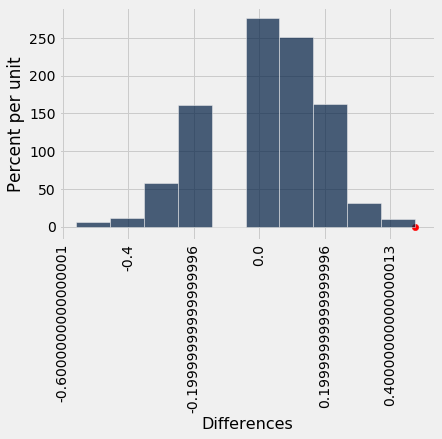

In [43]:
#: draw a histogram
Table().with_column('Differences', differences).hist()
plt.scatter(observed_difference, 0, color='red', s=40)

In [44]:
#: compute a p-value
np.count_nonzero(differences >= observed_difference) / n_repetitions

0.01

## Conclusion

- We reject the null hypothesis with a high degree of confidence.
- This is evidence that the treatment *caused* improvement.
    - *Because* this was an *randomized controlled trial*.